In [69]:
import copy
import math
import numpy as np

**Implementation of sigmoid function and derivative of a sigmoid function. Sigmoid function will be used for all activation units. Derivative will be used to calculate weight updates.**

In [70]:
def sigmoid(num):
    return 1/(1+math.exp(-num))

def percept_activation(outputs):
    sigmoid_ = np.vectorize(sigmoid)
    return np.array([sigmoid_(out) for out in outputs])

def der_sigmoid(num):
    return num * (1-num)

def activation_err(outputs):
    der_sigmoid_ = np.vectorize(der_sigmoid)
    return np.array([der_sigmoid_(out) for out in outputs])

**Implementation of forward pass**

In [71]:
def calc_forward_pass(weights, x):
    output = np.concatenate((x, np.ones((1, len(x)))), axis = 1)
    layer_outputs = [output]
    for w in weights:
        output = output.dot(w)
        output = percept_activation(output)
        output = np.concatenate((output, np.ones((1, len(output)))), axis=1)
        layer_outputs.insert(0, output)
    return output, layer_outputs


**Implementation of backward pass with momentum, where momentum is zero, when momentum is not to be used.**

In [72]:
def back_propagate_error(weights, error, layer_outputs, lr_rate, momentum = 0, w_grad = None):
    error_props = - error * activation_err(layer_outputs[0][:, :-1])

    new_weight_grads = []

    for i, (w,o) in enumerate(zip(weights, layer_outputs[1:])):
        dw = o.T.dot(error_props)
        dw = lr_rate * dw

        if w_grad is not None:
            dw = dw + momentum * w_grad[i]

        new_weight_grads.append(dw)
        weights[i] = w - dw
        error_props = error_props.dot(w.T[:,:-1]) * (activation_err(o[:,:-1]))

    return weights, new_weight_grads


**Helper functions which calculate mse error and check if any sample has more than 0.05 error.**

In [73]:
def get_errors(X, Y, weights, out = False):
    total_errors = 0
    valid_error_threshold = True
    for x, y in zip(X, Y):
        output, layer_outputs = calc_forward_pass(weights, x)

        if out and abs(output[0][0] -y) > 0.5:
            print("Predicted: " + str(output[0][0]) + " True:" + str(y))

        if abs(output[0][0] - y) > 0.05:
            valid_error_threshold = False
        if abs(output[0][0] - y) > 0.5:
            total_errors += 1
    if out:
        print("Total errors:" + str(total_errors))
    return valid_error_threshold

def get_mse_error(X, Y, weights):
    total_sq = 0
    for x,y in zip(X, Y):
        output, layer_output = calc_forward_pass(weights, x)
        total_sq += (output[0][0] - y) ** 2
    return total_sq / len(X)

**Actual function which trains the neural network on given lr_rate and momentum**

In [74]:
def  train_nn(X, Y, weights, lr_rate, momentum):
    loop_count = 0
    epoch_error_map = {}
    w_grads = None
    saved_weights = copy.deepcopy(weights)
    while True:
        loop_count += 1

        if loop_count > 100000:
            loop_count = 0
            weights = saved_weights
            epoch_error_map={}
            print("Resetting for lr_rate:" + str(lr_rate))

        threshold = get_errors(X, Y, weights, False)
        if threshold:
            epoch_error_map[loop_count]= get_mse_error(X, Y, weights)
            return loop_count, epoch_error_map

        if loop_count%100 == 0:
            epoch_error_map[loop_count]= get_mse_error(X, Y, weights)
        
        # Randomises the order of samples for each epoch
        # Uses samples one by one for stochastic descent
        for i in np.random.randint(0, len(X), 16):
            x = X[i]
            y = Y[i]
            output, layer_outputs = calc_forward_pass(weights, x)
            error = (y - output[0][0])
            weights.reverse()
            weights, w_grads = back_propagate_error(weights, error, layer_outputs, lr_rate, momentum, w_grads)
            weights.reverse()


In the above train implementation, the training is restarted with the same weights if the number of epochs cross 1lac. This was done because sometimes the training gets stuck in local minima and doesnt come out of it for a lot of time. In such cases, the training is restarted with the same weights.

Since in epoch the samples are used randomly, the chances to encounter same local minima are miniscule.

The number of epochs required for the training to reach the threshold of less than 0.05 error for every sample, although depends on learning rates, but are also dependent on initial condition (weights) and also the random draw of samples from the dataset.

It was noted that with same learning rate, the number of epochs required to reach threshold, changed in different runs. Primarily because in another run, the random samples drawn, directed the weights towards a minima faster/slower.

To take this into account, multiple runs with same algorithm were performed and the average epochs were taken into consideration.

**Function which returns the dataset**

In [75]:
def get_dataset():
    X = []
    Y = []
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    x = np.array([i,j,k,l])
                    x.shape = (1,4)
                    X.append(x)
                    Y.append((i+j+k+l) % 2)
    return X, Y


**1. Initialize all weights with random value between -1 and 1**

In [76]:
X, Y = get_dataset()

# initial weights
w1 = np.random.uniform(-1, 1, (5,4))
w2 = np.random.uniform(-1, 1, (5,1))


**Randomize the order of samples in each epoch and use stochastic gradient descent**

In [77]:
epochs_lr_map = {}
for i in range(5, 55, 5):
    lr_rate = i/100
    epochs_lr_map[lr_rate] = {}

    for j in range(4):
        weights = [w1, w2]
        epochs_lr_map[lr_rate][(j%2)*0.9] = {"epochs": [], "error_map": {}}
        epochs, epoch_error_map = train_nn(X,Y, weights, lr_rate, (j%2)*0.9)
        print("lr_rate: " + str(lr_rate) + ", momentum:" + str((j%2)*0.9) + ", epochs:" + str(epochs))
        epochs_lr_map[lr_rate][(j%2)*0.9]["epochs"].append(epochs)
        if epochs <= min(epochs_lr_map[lr_rate][(j%2)*0.9]["epochs"]):
            epochs_lr_map[lr_rate][(j%2)*0.9]["error_map"] = epoch_error_map


Resetting for lr_rate:0.05
lr_rate: 0.05, momentum:0.0, epochs:45653
lr_rate: 0.05, momentum:0.9, epochs:26619
Resetting for lr_rate:0.05
lr_rate: 0.05, momentum:0.0, epochs:69729
lr_rate: 0.05, momentum:0.9, epochs:23568
Resetting for lr_rate:0.1
lr_rate: 0.1, momentum:0.0, epochs:37484
lr_rate: 0.1, momentum:0.9, epochs:11058
Resetting for lr_rate:0.1
lr_rate: 0.1, momentum:0.0, epochs:48757
lr_rate: 0.1, momentum:0.9, epochs:33106
lr_rate: 0.15, momentum:0.0, epochs:21754
lr_rate: 0.15, momentum:0.9, epochs:18158
lr_rate: 0.15, momentum:0.0, epochs:22890
Resetting for lr_rate:0.15
lr_rate: 0.15, momentum:0.9, epochs:37240
Resetting for lr_rate:0.2
lr_rate: 0.2, momentum:0.0, epochs:16413
lr_rate: 0.2, momentum:0.9, epochs:5095
lr_rate: 0.2, momentum:0.0, epochs:12920
lr_rate: 0.2, momentum:0.9, epochs:54554
lr_rate: 0.25, momentum:0.0, epochs:51370
lr_rate: 0.25, momentum:0.9, epochs:26649
lr_rate: 0.25, momentum:0.0, epochs:49078
lr_rate: 0.25, momentum:0.9, epochs:8741
lr_rate: 0.

In [78]:
def plot_x_y_vals(x_vals, y_vals, x_label, y_label, label, line_titles):
    for i in range(len(x_vals)):
        plt.plot(x_vals[i], y_vals[i], label=line_titles[i])
    plt.title(label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


In [79]:
# Taking the backup of results in the notebook, because the results take a lot of time to compute
epochs_lr_map_bck = copy.deepcopy(epochs_lr_map)

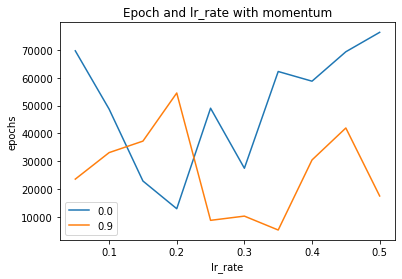

In [80]:
import matplotlib.pyplot as plt

lr_epoch_momentum_data = {}

for lr_rate in epochs_lr_map_bck:
    for momentum in epochs_lr_map_bck[lr_rate]:
        if momentum not in lr_epoch_momentum_data:
            lr_epoch_momentum_data[momentum] = {"epochs":[], "lr_rate":[]}
        
        data = epochs_lr_map_bck[lr_rate][momentum]
        data["avg_epochs"] = sum(data["epochs"]) / len(data["epochs"])
        lr_epoch_momentum_data[momentum]["epochs"].append(data["avg_epochs"]) 
        lr_epoch_momentum_data[momentum]["lr_rate"].append(lr_rate) 
        
lemd = lr_epoch_momentum_data
plot_x_y_vals([lr_epoch_momentum_data[a]["lr_rate"] for a in lemd], [lr_epoch_momentum_data[a]["epochs"] for a in lemd], "lr_rate", "epochs", "Epoch and lr_rate with momentum", [str(a) for a in lemd])
        

**As can be seen in the above figure, In most cases the training with momentum = 0.9 is faster, and converges in less steps. However the epochs also depend on the order in which samples are chosen, and are responsible for directing the training towards a better/worse minima.**

**Overall there are better chances of a training to converge faster with momentum.**

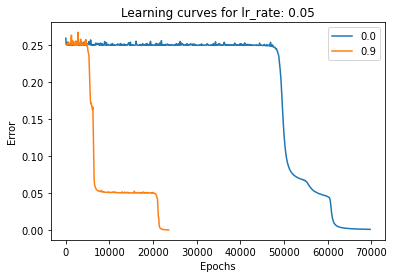

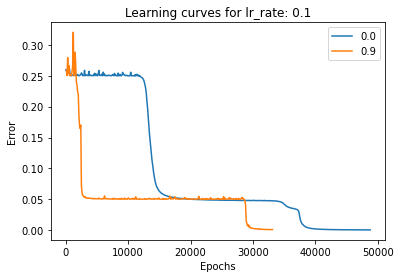

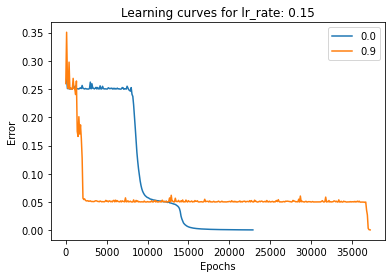

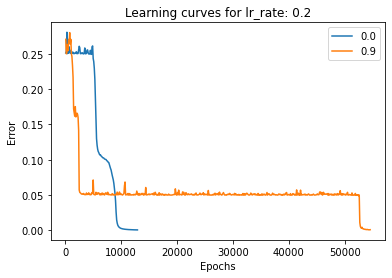

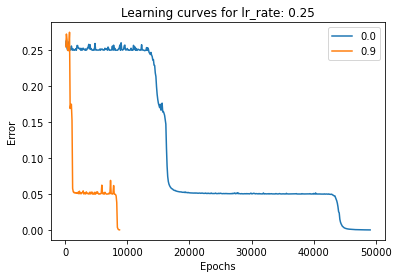

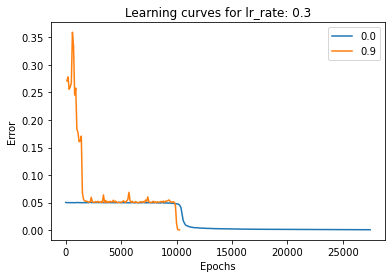

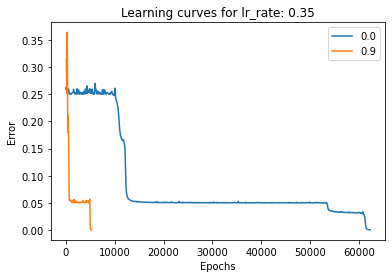

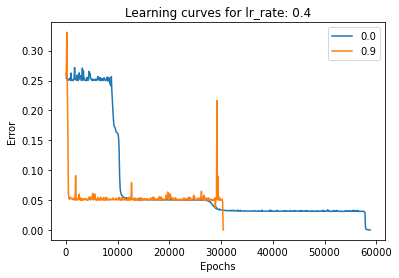

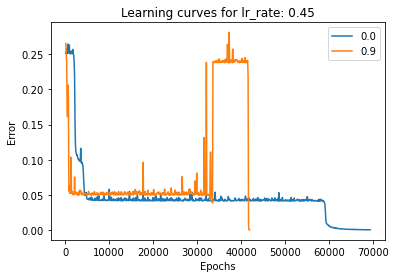

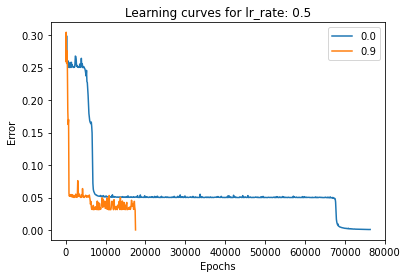

In [84]:
for lr_rate in epochs_lr_map_bck:
    to_plot={"epochs":[], "errors":[], "titles":[]}
    for momentum in epochs_lr_map_bck[lr_rate]:
        to_plot["epochs"].append(list(epochs_lr_map_bck[lr_rate][momentum]["error_map"].keys()))
        to_plot["errors"].append(list(epochs_lr_map_bck[lr_rate][momentum]["error_map"].values()))
        to_plot["titles"].append(str(momentum))
    plot_x_y_vals(to_plot["epochs"], to_plot["errors"], "Epochs", "Error", "Learning curves for lr_rate: " + str(lr_rate),to_plot["titles"])

In these figures we see that, for different learning rates, the algorithm almost always converges faster for the training with momentum. There are few cases where the training with momentum takes more time. That occurs because sometimes training with momentum takes a different path, which leads it to a local minima that is difficult to escape.

However more often than not, with momentum the training quickly comes out of the minima. In the graph, we can see the local minima indicated by a straight horizontal line. We see that neural network is stuck in the local minima for most of the duration. and a lot of epochs. 

We also see that in some of the trainings, there are multiple horizintal lines(stairs like structure), which indicates that the during training, the algorithm got stuck in multiple local minimas.

Overall, when there is momentum, it takes less time for training to come out of the local minima. In most cases, we see that when momentum = 0, the horizontal straight line is significantly longer. Indicating that it took a lot of epochs to get out of the local minima.

Another thing that can be observed here is that, when learning rate is higher, out model is able to take larger step, and get out of minima's faster. This effect can be observed in the plots, when learning rates are high, the training seem to have taken less number of steps in most cases except few.

Once again, Training on same weight again, with same momentum and learning rate, taakes a different amount of time, because we are taking out the samples in random order. Which results in different epochs for same configuration. So the above plots only show a most likely estimation and not the absolute truth.

We have trained the problem on same configurations multiple times and taken average of the epochs to generate the plots.

We can also see that, in some plots, momentum = 0 and 0.9 take completely differnt path(stairs in the plot) to reach the bottom threshold. 